In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import SpectralEmbedding
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import ward, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook

In [2]:
# Read in the basketball-reference dataframe
df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Basketball-reference data\heights_and_positions_df(2001-2024).csv")
height_pos_df = df.drop(columns = ['Unnamed: 0'])

In [3]:
height_pos_df

,Player,Pos,Ht,Roster
0,Bruce Bowen,SF,6-7,2001MIA
1,Anthony Carter,PG,6-1,2001MIA
2,Duane Causwell,C,7-0,2001MIA
3,Cedric Ceballos,SF,6-7,2001MIA
4,Ricky Davis,SG,6-6,2001MIA
...,...,...,...,...
13216,Nick Smith Jr.,SG,6-2,2024CHO
13217,JT Thor,PF,6-10,2024CHO
13218,P.J. Washington,PF,6-7,2024CHO
13219,Grant Williams,PF,6-6,2024CHO


In [4]:
# Read in the basketball-reference dataframe
df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Basketball-reference data\heights_and_positions_df_withMP(2001-2024).csv")
df = df.drop(columns = ['Unnamed: 0'])
df = df[df['Player'] != 'Team Totals']

In [5]:
df

,Player,Pos,G,MP,Roster
0,Anthony Mason,PF,80,40.7,2001MIA
1,Eddie Jones,SG,63,36.2,2001MIA
2,Tim Hardaway,PG,77,33.9,2001MIA
3,Brian Grant,C,82,33.8,2001MIA
4,Bruce Bowen,SF,82,32.7,2001MIA
...,...,...,...,...,...
13920,Nathan Mensah,C,25,12.3,2024CHO
13921,Leaky Black,SF,26,10.9,2024CHO
13922,Frank Ntilikina,PG,5,8.6,2024CHO
13923,Amari Bailey,PG,10,6.5,2024CHO


In [6]:
merged_df = pd.merge(height_pos_df, df, on=['Player', 'Pos', 'Roster'])

In [7]:
merged_df

,Player,Pos,Ht,Roster,G,MP
0,Bruce Bowen,SF,6-7,2001MIA,82,32.7
1,Anthony Carter,PG,6-1,2001MIA,72,22.6
2,Duane Causwell,C,7-0,2001MIA,31,12.4
3,Cedric Ceballos,SF,6-7,2001MIA,27,14.6
4,Ricky Davis,SG,6-6,2001MIA,7,10.0
...,...,...,...,...,...,...
13205,Nick Smith Jr.,SG,6-2,2024CHO,51,14.3
13206,JT Thor,PF,6-10,2024CHO,63,12.4
13207,P.J. Washington,PF,6-7,2024CHO,44,29.2
13208,Grant Williams,PF,6-6,2024CHO,29,30.6


In [8]:
nba_teams = {
    'Miami Heat': 'MIA',
    'Chicago Bulls': 'CHI',
    'Philadelphia 76ers': 'PHI',
    'New Jersey Nets': 'NJN',
    'Golden State Warriors': 'GSW',
    'Boston Celtics': 'BOS',
    'Indiana Pacers': 'IND',
    'Atlanta Hawks': 'ATL',
    'New York Knicks': 'NYK',
    'Toronto Raptors': 'TOR',
    'Cleveland Cavaliers': 'CLE',
    'Orlando Magic': 'ORL',
    'Phoenix Suns': 'PHO',
    'Denver Nuggets': 'DEN',
    'Houston Rockets': 'HOU',
    'Minnesota Timberwolves': 'MIN',
    'San Antonio Spurs': 'SAS',
    'Portland Trail Blazers': 'POR',
    'Sacramento Kings': 'SAC',
    'Charlotte Hornets': 'CHH',
    'Detroit Pistons': 'DET',
    'Dallas Mavericks': 'DAL',
    'Seattle SuperSonics': 'SEA',
    'Vancouver Grizzlies': 'VAN',
    'Los Angeles Lakers': 'LAL',
    'Los Angeles Clippers': 'LAC',
    'Utah Jazz': 'UTA',
    'Washington Wizards': 'WAS',
    'Milwaukee Bucks': 'MIL',
    'Memphis Grizzlies': 'MEM',
    'New Orleans Hornets': 'NOH',
    'New Orleans/Oklahoma City Hornets': 'NOK',
    'Oklahoma City Thunder': 'OKC',
    'Brooklyn Nets': 'BRK',
    'New Orleans Pelicans': 'NOP',
    'Charlotte Bobcats': 'CHO',
    'New Charlotte Hornets': 'CHA'
}

seasons = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
teams = list(nba_teams.values())

In [9]:
season_dfs = []

for season in seasons:
    season_df = merged_df[merged_df['Roster'].str.contains(season, na=False)].copy()
    season_df['Team'] = season_df['Roster'].apply(lambda roster: roster[4:])
    
    for team in teams:
        if team in season_df['Team'].values:
            team_df = season_df[season_df['Roster'].str.contains(team, na=False)].copy()
            team_df = team_df[(team_df['G'] >= 30) & (team_df['MP'] >= 15)]
            season_dfs.append(team_df.drop(columns=['G', 'MP', 'Team']))

In [10]:
individual_heights_df = pd.concat(season_dfs, ignore_index=True)

In [11]:
individual_heights_df

,Player,Pos,Ht,Roster
0,Bruce Bowen,SF,6-7,2001MIA
1,Anthony Carter,PG,6-1,2001MIA
2,Brian Grant,C,6-9,2001MIA
3,A.C. Green,PF,6-9,2001MIA
4,Tim Hardaway,PG,6-0,2001MIA
...,...,...,...,...
6929,Brandon Miller,SF,6-9,2024CHO
6930,Nick Richards,C,7-0,2024CHO
6931,Terry Rozier,SG,6-1,2024CHO
6932,Ish Smith,PG,6-0,2024CHO


In [12]:
def height_to_inches(str_height):
    feet = str_height.split('-')[0]
    inches = str_height.split('-')[1]
    height = int(feet) * 12 + int(inches)
    return height

individual_heights_df = individual_heights_df[~pd.isna(individual_heights_df['Ht'])].copy()
individual_heights_df['Ht'] = individual_heights_df['Ht'].apply(height_to_inches)

In [13]:
avg_heights_df = (individual_heights_df.groupby(['Roster', 'Pos'])['Ht'].mean().round(2).unstack().reset_index())
desired_order = ['Roster', 'PG', 'SG', 'SF', 'PF', 'C']
avg_heights_df = avg_heights_df.reindex(columns=desired_order).set_index('Roster').dropna()
avg_heights_df

Pos,PG,SG,SF,PF,C
Roster,,,,,
2001ATL,73.33,75.50,80.50,81.0,84.5
2001BOS,74.00,77.00,79.50,81.0,83.0
2001CHH,75.00,72.00,80.00,82.5,83.0
2001CHI,73.50,77.50,79.00,81.0,83.0
2001CLE,74.00,77.33,78.67,80.0,82.0
...,...,...,...,...,...
2024SAC,74.50,77.33,80.00,80.5,82.0
2024SAS,74.50,77.00,78.50,80.0,85.0
2024TOR,74.25,78.00,80.00,80.0,84.0


In [14]:
avg_heights_df.iloc[0]

Pos
PG    73.33
SG    75.50
SF    80.50
PF    81.00
C     84.50
Name: 2001ATL, dtype: float64

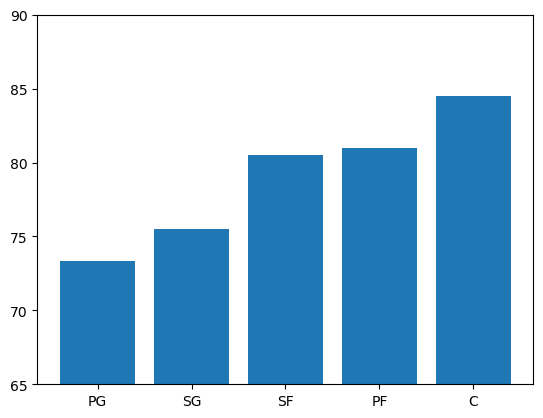

In [15]:
plt.bar(avg_heights_df.columns, avg_heights_df.iloc[0])
plt.ylim(65, 90)
plt.show()

In [16]:
# Standardizing the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(avg_heights_df)
standardized_df = pd.DataFrame(standardized_data, columns=avg_heights_df.columns, index=avg_heights_df.index)

In [17]:
standardized_df

Pos,PG,SG,SF,PF,C
Roster,,,,,
2001ATL,-0.502593,-1.096619,0.986247,-0.000298,1.221444
2001BOS,-0.076859,0.097267,0.136226,-0.000298,0.011810
2001CHH,0.558564,-3.882351,0.561236,1.183520,0.011810
2001CHI,-0.394571,0.495229,-0.288785,-0.000298,0.011810
2001CLE,-0.076859,0.359921,-0.569293,-0.789510,-0.794613
...,...,...,...,...,...
2024SAC,0.240852,0.359921,0.561236,-0.394904,-0.794613
2024SAS,0.240852,0.097267,-0.713796,-0.789510,1.624655
2024TOR,0.081996,0.893190,0.561236,-0.789510,0.818232


In [18]:
embedding = SpectralEmbedding(n_components=2, affinity='rbf')
transformed_data = embedding.fit_transform(standardized_df)

In [19]:
le_df = pd.DataFrame(transformed_data, index=standardized_df.index, columns = ['LE_Component_1', 'LE_Component_2']).reset_index()

In [20]:
records_df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Basketball-reference data\team_records_2001-2024.csv")

records_df['Rank-Statistic'] = records_df['Rank-Statistic'].str.replace('-', '')

records_df = records_df.set_index('Rank-Statistic')

records_df = records_df[~records_df['Overall'].isnull() & (records_df['Overall'] != 'Overall')]

records_df = records_df.copy()
records_df[['Wins', 'Losses']] = records_df['Overall'].str.split('-', expand=True)
records_df['Wins'] = records_df['Wins'].astype(int)
records_df['Losses'] = records_df['Losses'].astype(int)
records_df['Win_Percentage'] = records_df['Wins'] / (records_df['Wins'] + records_df['Losses'])

records_df = records_df.drop(columns = ['Overall', 'Wins', 'Losses'])

In [21]:
le_df = pd.merge(le_df, records_df.reset_index().rename(columns={'Rank-Statistic': 'Roster'}), on='Roster').set_index('Roster')

In [22]:
le_df

,LE_Component_1,LE_Component_2,Win_Percentage
Roster,,,
2001ATL,-0.001866,0.001744,0.304878
2001BOS,-0.000356,-0.000260,0.439024
2001CHH,0.001583,0.009940,0.560976
2001CHI,-0.000088,-0.001143,0.182927
2001CLE,0.002910,-0.002024,0.365854
...,...,...,...
2024SAC,0.000144,-0.001687,0.560976
2024SAS,0.001001,0.003587,0.268293
2024TOR,-0.001299,-0.000038,0.304878


In [23]:
mean_heights_df = pd.read_csv('mean_heights_by_roster.csv').drop(columns=['Unnamed: 0'])

In [24]:
std_heights_df = pd.read_csv('std_heights_by_roster.csv').drop(columns=['Unnamed: 0'])

In [25]:
le_df = pd.merge(le_df.reset_index(), mean_heights_df, on = 'Roster').set_index('Roster')

In [26]:
le_df = pd.merge(le_df.reset_index(), std_heights_df, on = 'Roster').set_index('Roster')

In [27]:
le_df

,LE_Component_1,LE_Component_2,Win_Percentage,Avg Height,Standard Deviation of Roster Height
Roster,,,,,
2001ATL,-0.001866,0.001744,0.304878,79.7,4.73
2001BOS,-0.000356,-0.000260,0.439024,79.3,3.68
2001CHH,0.001583,0.009940,0.560976,80.0,3.83
2001CHI,-0.000088,-0.001143,0.182927,78.3,3.60
2001CLE,0.002910,-0.002024,0.365854,79.4,2.62
...,...,...,...,...,...
2024SAC,0.000144,-0.001687,0.560976,78.7,2.60
2024SAS,0.001001,0.003587,0.268293,79.4,3.73
2024TOR,-0.001299,-0.000038,0.304878,78.4,2.84


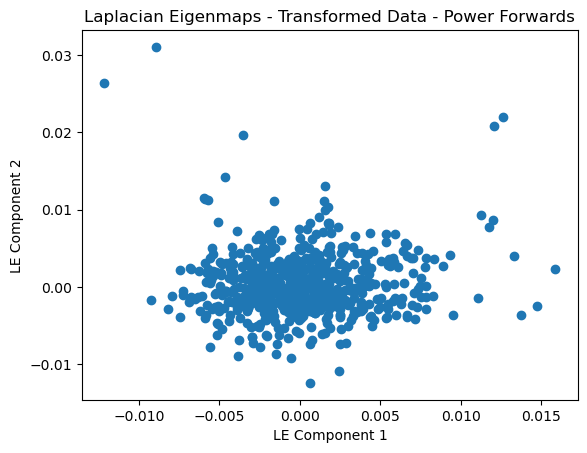

In [28]:
plt.scatter(le_df['LE_Component_1'], le_df['LE_Component_2'])
plt.title(f'Laplacian Eigenmaps - Transformed Data - Power Forwards')
plt.xlabel('LE Component 1')
plt.ylabel('LE Component 2')
plt.show()

In [29]:
le_df['Season'] = list(le_df.reset_index()['Roster'].apply(lambda roster: str(roster)[:4]))
le_df['Season'] = le_df['Season'].apply(lambda season: int(season))

In [30]:
le_df

,LE_Component_1,LE_Component_2,Win_Percentage,Avg Height,Standard Deviation of Roster Height,Season
Roster,,,,,,
2001ATL,-0.001866,0.001744,0.304878,79.7,4.73,2001
2001BOS,-0.000356,-0.000260,0.439024,79.3,3.68,2001
2001CHH,0.001583,0.009940,0.560976,80.0,3.83,2001
2001CHI,-0.000088,-0.001143,0.182927,78.3,3.60,2001
2001CLE,0.002910,-0.002024,0.365854,79.4,2.62,2001
...,...,...,...,...,...,...
2024SAC,0.000144,-0.001687,0.560976,78.7,2.60,2024
2024SAS,0.001001,0.003587,0.268293,79.4,3.73,2024
2024TOR,-0.001299,-0.000038,0.304878,78.4,2.84,2024


In [31]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook
from bokeh.models import ColorBar
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.layouts import column
from bokeh.io import show
from bokeh.models import Slider, CustomJS
from bokeh.layouts import row

In [32]:
avg_heights_df

Pos,PG,SG,SF,PF,C
Roster,,,,,
2001ATL,73.33,75.50,80.50,81.0,84.5
2001BOS,74.00,77.00,79.50,81.0,83.0
2001CHH,75.00,72.00,80.00,82.5,83.0
2001CHI,73.50,77.50,79.00,81.0,83.0
2001CLE,74.00,77.33,78.67,80.0,82.0
...,...,...,...,...,...
2024SAC,74.50,77.33,80.00,80.5,82.0
2024SAS,74.50,77.00,78.50,80.0,85.0
2024TOR,74.25,78.00,80.00,80.0,84.0


In [33]:
# Create a dictionary to store position heights for each roster
position_heights = {}
for roster in avg_heights_df.index:
    position_heights[roster] = avg_heights_df.loc[roster].tolist()

# Create source for the scatter plot
scatter_source = ColumnDataSource(le_df)

# Create source for the bar chart
bar_source = ColumnDataSource(data={
    'positions': list(avg_heights_df.columns),
    'heights': avg_heights_df.iloc[0].tolist(),  # Initialize with first roster
    'roster': [avg_heights_df.index[0]] * len(avg_heights_df.columns)
})

# Create the scatter plot
p1 = figure(
    title='Laplacian Eigenmaps for Height Histograms by Roster',
    x_axis_label='Component 1',
    y_axis_label='Component 2',
    width=800,
    height=600,
    tools='pan,wheel_zoom,box_zoom,reset,save'
)

# Define color mapper
mapper = linear_cmap(
    field_name='Season',
    palette=Viridis256,
    low=le_df['Season'].min(),
    high=le_df['Season'].max()
)

# Add scatter points
p1.scatter(
    x='LE_Component_1',
    y='LE_Component_2',
    source=scatter_source,
    size=10,
    alpha=0.7,
    color=mapper,
    legend_label='Roster Heights'
)

# Create the bar plot
p2 = figure(
    title='Average Heights by Position',
    x_axis_label='Position',
    y_axis_label='Height (inches)',
    width=400,
    height=600,
    y_range=(65, 90),  # Set y-axis range
    x_range=list(avg_heights_df.columns)  # Set x-axis categories
)

# Add bars
bars = p2.vbar(
    x='positions',
    top='heights',
    width=0.8,
    source=bar_source
)

# Create the callback code
callback = CustomJS(args=dict(
    bar_source=bar_source,
    position_heights=position_heights,
    scatter_source=scatter_source
), code="""
    // Get the index of the hovered point
    const ind = cb_data.index.indices[0];
    
    // Get the roster from the scatter source data
    const roster = scatter_source.data.Roster[ind];
    
    // Update the bar heights
    bar_source.data.heights = position_heights[roster];
    bar_source.data.roster = Array(bar_source.data.positions.length).fill(roster);
    
    // Trigger update
    bar_source.change.emit();
    
    // Update plot title
    const plot = Bokeh.documents[0].get_model_by_name('position_plot');
    if (plot) {
        plot.title.text = `Average Heights by Position for ${roster}`;
    }
""")

# Add hover tool with callback
hover = HoverTool(
    tooltips=[('Roster', '@Roster')],
    callback=callback,
    renderers=[p1.renderers[0]]
)
p1.add_tools(hover)

# Add color bar
color_bar = ColorBar(
    color_mapper=mapper['transform'],
    width=8,
    location=(0,0),
    title='Season'
)
p1.add_layout(color_bar, 'right')

# Name the position plot so we can reference it in the callback
p2.name = 'position_plot'

# Create the layout
layout = row(p1, p2)

# Show the plot
show(layout)

In [34]:
# Creating an average source to get the average values for each season
season_avg = le_df.reset_index().groupby('Season')['LE_Component_1', 'LE_Component_2'].mean().reset_index()
source = ColumnDataSource(season_avg)

# Creating padding for the bounds of the axes
x_padding = (season_avg['LE_Component_1'].max() - season_avg['LE_Component_1'].min()) * 0.1
y_padding = (season_avg['LE_Component_2'].max() - season_avg['LE_Component_2'].min()) * 0.1

# Create the figure
p = figure(
    title='Progression of Seasonal Averages',
    x_axis_label='Component 1',
    y_axis_label='Component 2',
    width=800,
    height=600,
    tools='pan, wheel_zoom, box_zoom, reset, save',
    x_range=(season_avg['LE_Component_1'].min() - x_padding, season_avg['LE_Component_1'].max() + x_padding),
    y_range=(season_avg['LE_Component_2'].min() - y_padding, season_avg['LE_Component_2'].max() + y_padding)
)

# Define a color map based on the Win_Percentage values
mapper = linear_cmap(field_name='Season', palette=Viridis256, low=le_df['Season'].min(), high=le_df['Season'].max())

# Add the scatter points for averages
scatter = p.scatter(
    x='LE_Component_1',
    y='LE_Component_2',
    source=source,
    size=15,
    color=mapper,
    alpha=0.8,
    legend_label='Season Averages'
)

# Add the connecting lines between seasons
# We need to sort by season to ensure correct line progression
sorted_avg = season_avg.sort_values('Season')
p.line(
    x=sorted_avg['LE_Component_1'],
    y=sorted_avg['LE_Component_2'],
    line_color='blue',
    line_width=2,
    alpha=0.6,
    legend_label='Progression'
)

# Add hover tool
hover = HoverTool(renderers=[scatter])
hover.tooltips = [
    ('Season', '@Season')
]
p.add_tools(hover)

# Configure legend
p.legend.location = "top_right"
p.legend.click_policy = "hide"

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0), title='Season')
p.add_layout(color_bar, 'right')

# Show the plot
show(p)

C:\Users\vaugh\AppData\Local\Temp\ipykernel_9352\3074553050.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  season_avg = le_df.reset_index().groupby('Season')['LE_Component_1', 'LE_Component_2'].mean().reset_index()


In [35]:
# Assuming 'Season' column exists in le_df and contains the season info
# Creating a ColumnDataSource for Bokeh with the full dataset
source = ColumnDataSource(le_df)

# Creating another ColumnDataSource for filtered data
filtered_source = ColumnDataSource(data=source.data)

# Calculating a padding for the axes
x_padding = (le_df['LE_Component_1'].max() - le_df['LE_Component_1'].min()) * 0.05  # 5% padding
y_padding = (le_df['LE_Component_2'].max() - le_df['LE_Component_2'].min()) * 0.05  # 5% padding

# Creating the figure for the bokeh plot
p = figure(
    title='Laplacian Eigenmaps for Average Roster Height - by Position',
    x_axis_label='Component 1',
    y_axis_label='Component 2',
    width=800,
    height=600,
    tools='pan, wheel_zoom, box_zoom, reset, save',
    x_range=(le_df['LE_Component_1'].min() - x_padding, le_df['LE_Component_1'].max() + x_padding),
    y_range=(le_df['LE_Component_2'].min() - y_padding, le_df['LE_Component_2'].max() + y_padding)
)

# Define a color map based on the Win_Percentage values
mapper = linear_cmap(field_name='Win_Percentage', palette=Viridis256, low=le_df['Win_Percentage'].min(), high=le_df['Win_Percentage'].max())

# Creating the scatter plot
p.scatter(
    x='LE_Component_1',
    y='LE_Component_2',
    source=filtered_source,
    size=10,
    alpha=0.7,
    color=mapper,
    legend_label='Roster Heights by Position'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster'),
    ('Season', '@Season'),
    ('Win_Percentage', '@Win_Percentage{0.00}')
]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0, 0), title='Win_Percentage')
p.add_layout(color_bar, 'right')

# Creating a slider for season filtering
slider = Slider(start=le_df['Season'].min(), end=le_df['Season'].max(), value=le_df['Season'].min(), step=1, title='Season')

# JavaScript callback to filter the data
callback = CustomJS(args=dict(source=source, filtered_source=filtered_source, slider=slider), code="""
    const season = slider.value;
    const data = source.data;
    const filtered_data = { LE_Component_1: [], LE_Component_2: [], Win_Percentage: [], Roster: [], Season: [] };

    for (let i = 0; i < data['Season'].length; i++) {
        if (data['Season'][i] === season) {
            filtered_data['LE_Component_1'].push(data['LE_Component_1'][i]);
            filtered_data['LE_Component_2'].push(data['LE_Component_2'][i]);
            filtered_data['Win_Percentage'].push(data['Win_Percentage'][i]);
            filtered_data['Roster'].push(data['Roster'][i]);
            filtered_data['Season'].push(data['Season'][i]);
        }
    }
    filtered_source.data = filtered_data;
    filtered_source.change.emit();
""")

slider.js_on_change('value', callback)

# Layout with the slider and the plot
layout = column(slider, p)

# Show the layout
show(layout)

In [52]:
le_df

,LE_Component_1,LE_Component_2,Win_Percentage,Season,Avg Height
Roster,,,,,
2001ATL,-0.001866,0.001744,0.304878,2001,79.7
2001BOS,-0.000356,-0.000260,0.439024,2001,79.3
2001CHH,0.001583,0.009940,0.560976,2001,80.0
2001CHI,-0.000088,-0.001143,0.182927,2001,78.3
2001CLE,0.002910,-0.002024,0.365854,2001,79.4
...,...,...,...,...,...
2024SAC,0.000144,-0.001687,0.560976,2024,78.7
2024SAS,0.001001,0.003587,0.268293,2024,79.4
2024TOR,-0.001299,-0.000038,0.304878,2024,78.4


In [37]:
# Creating a ColumnDataSource for Bokeh
source = ColumnDataSource(le_df)

# Creating the figure for the bokeh plot
p = figure(
    title = 'Laplacian Eigenmaps for Average Roster Height - by Position',
    x_axis_label = 'Component 1',
    y_axis_label = 'Component 2',
    width = 800,
    height = 600,
    tools = 'pan, wheel_zoom, box_zoom, reset, save'
)

# Define a color map based on the USG% values
mapper = linear_cmap(field_name='Avg Height', palette=Viridis256, low=le_df['Avg Height'].min(), high=le_df['Avg Height'].max())

# Creating the scatter plot
p.scatter(
    x = 'LE_Component_1',
    y = 'LE_Component_2',
    source = source,
    size = 10,
    alpha = 0.7,
    color = mapper,
    legend_label = 'Roster Heights by Position'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster')
                 ]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0), title='Avg Height')
p.add_layout(color_bar, 'right')

show(p)